In [4]:
from scipy.io import loadmat
from scipy.io import savemat 
import numpy as np
import matplotlib.pyplot as plt
from alphacsc import GreedyCDL
from alphacsc.utils import split_signal
from scipy import signal
from scipy.signal import butter, filtfilt
from matplotlib import gridspec
import time
from alphacsc import BatchCDL


In [5]:
def butter_lowpass(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    y = filtfilt(b, a, data)
    return y

def butter_highpass(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high')
    y = filtfilt(b, a, data)
    return y

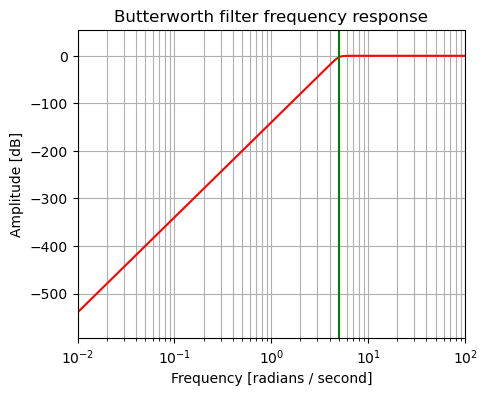

In [6]:
VIS_FILTER = True
if VIS_FILTER:         
    
    filt0rder         = 10
    Wn                = 5 #Hz
    b, a = signal.butter(filt0rder, Wn, 'hp', analog=True)
    w, h = signal.freqs(b, a)
    plt.figure(figsize=(5, 4))
    plt.semilogx(w, 20 * np.log10(abs(h)), 'r')
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(Wn, color='green') # cutoff frequency
    plt.show()
    

In [7]:
#filepath = '/data/sheng/MEG_source_data/case_0390/set2/parcel_ts/set2_parc2018yeo17_200_1000_weighted.npy'
#filepath = '/data/sheng/MEG_source_data/case_0390/set3/parcel_ts/set3_parc2018yeo17_200_1000_weighted.npy'
filepath = '/data/sheng/MEG_source_data/case_0390/set4/parcel_ts/set4_parc2018yeo17_200_1000_weighted.npy'

ori_fs             = 1000 # Original sampling rate (Hz)
decimate           = 10
parcelTS           = np.load(filepath) # data: channels x samples
print('MEG source time series dimension: ', parcelTS.shape)

MEG source time series dimension:  (200, 613000)


In [10]:
PARC_ID          = 65
aParcelTS        = parcelTS[PARC_ID]
fs               = ori_fs // decimate
LOW_PASS         = 7   #Hz
HI_PASS          = 0.5  #Hz
n_atoms          = 12
ATOM_DURATION    = 5 # in seconds



lowpass_data         = butter_lowpass(aParcelTS, LOW_PASS, ori_fs)
highpass             = butter_highpass(lowpass_data, HI_PASS, ori_fs)
data                 = signal.decimate(highpass, decimate)
del lowpass_data
print(aParcelTS.shape, highpass.shape, data.shape)

'''
filt0rder        = 10
Wn               = 1 # Hz
sos              = signal.butter(filt0rder, Wn, 'hp', fs=ori_fs, output='sos')
highpass         = signal.sosfilt(sos, aParcelTS)
data             = signal.decimate(highpass, decimate)

'''

(613000,) (613000,) (61300,)


"\nfilt0rder        = 10\nWn               = 1 # Hz\nsos              = signal.butter(filt0rder, Wn, 'hp', fs=ori_fs, output='sos')\nhighpass         = signal.sosfilt(sos, aParcelTS)\ndata             = signal.decimate(highpass, decimate)\n\n"

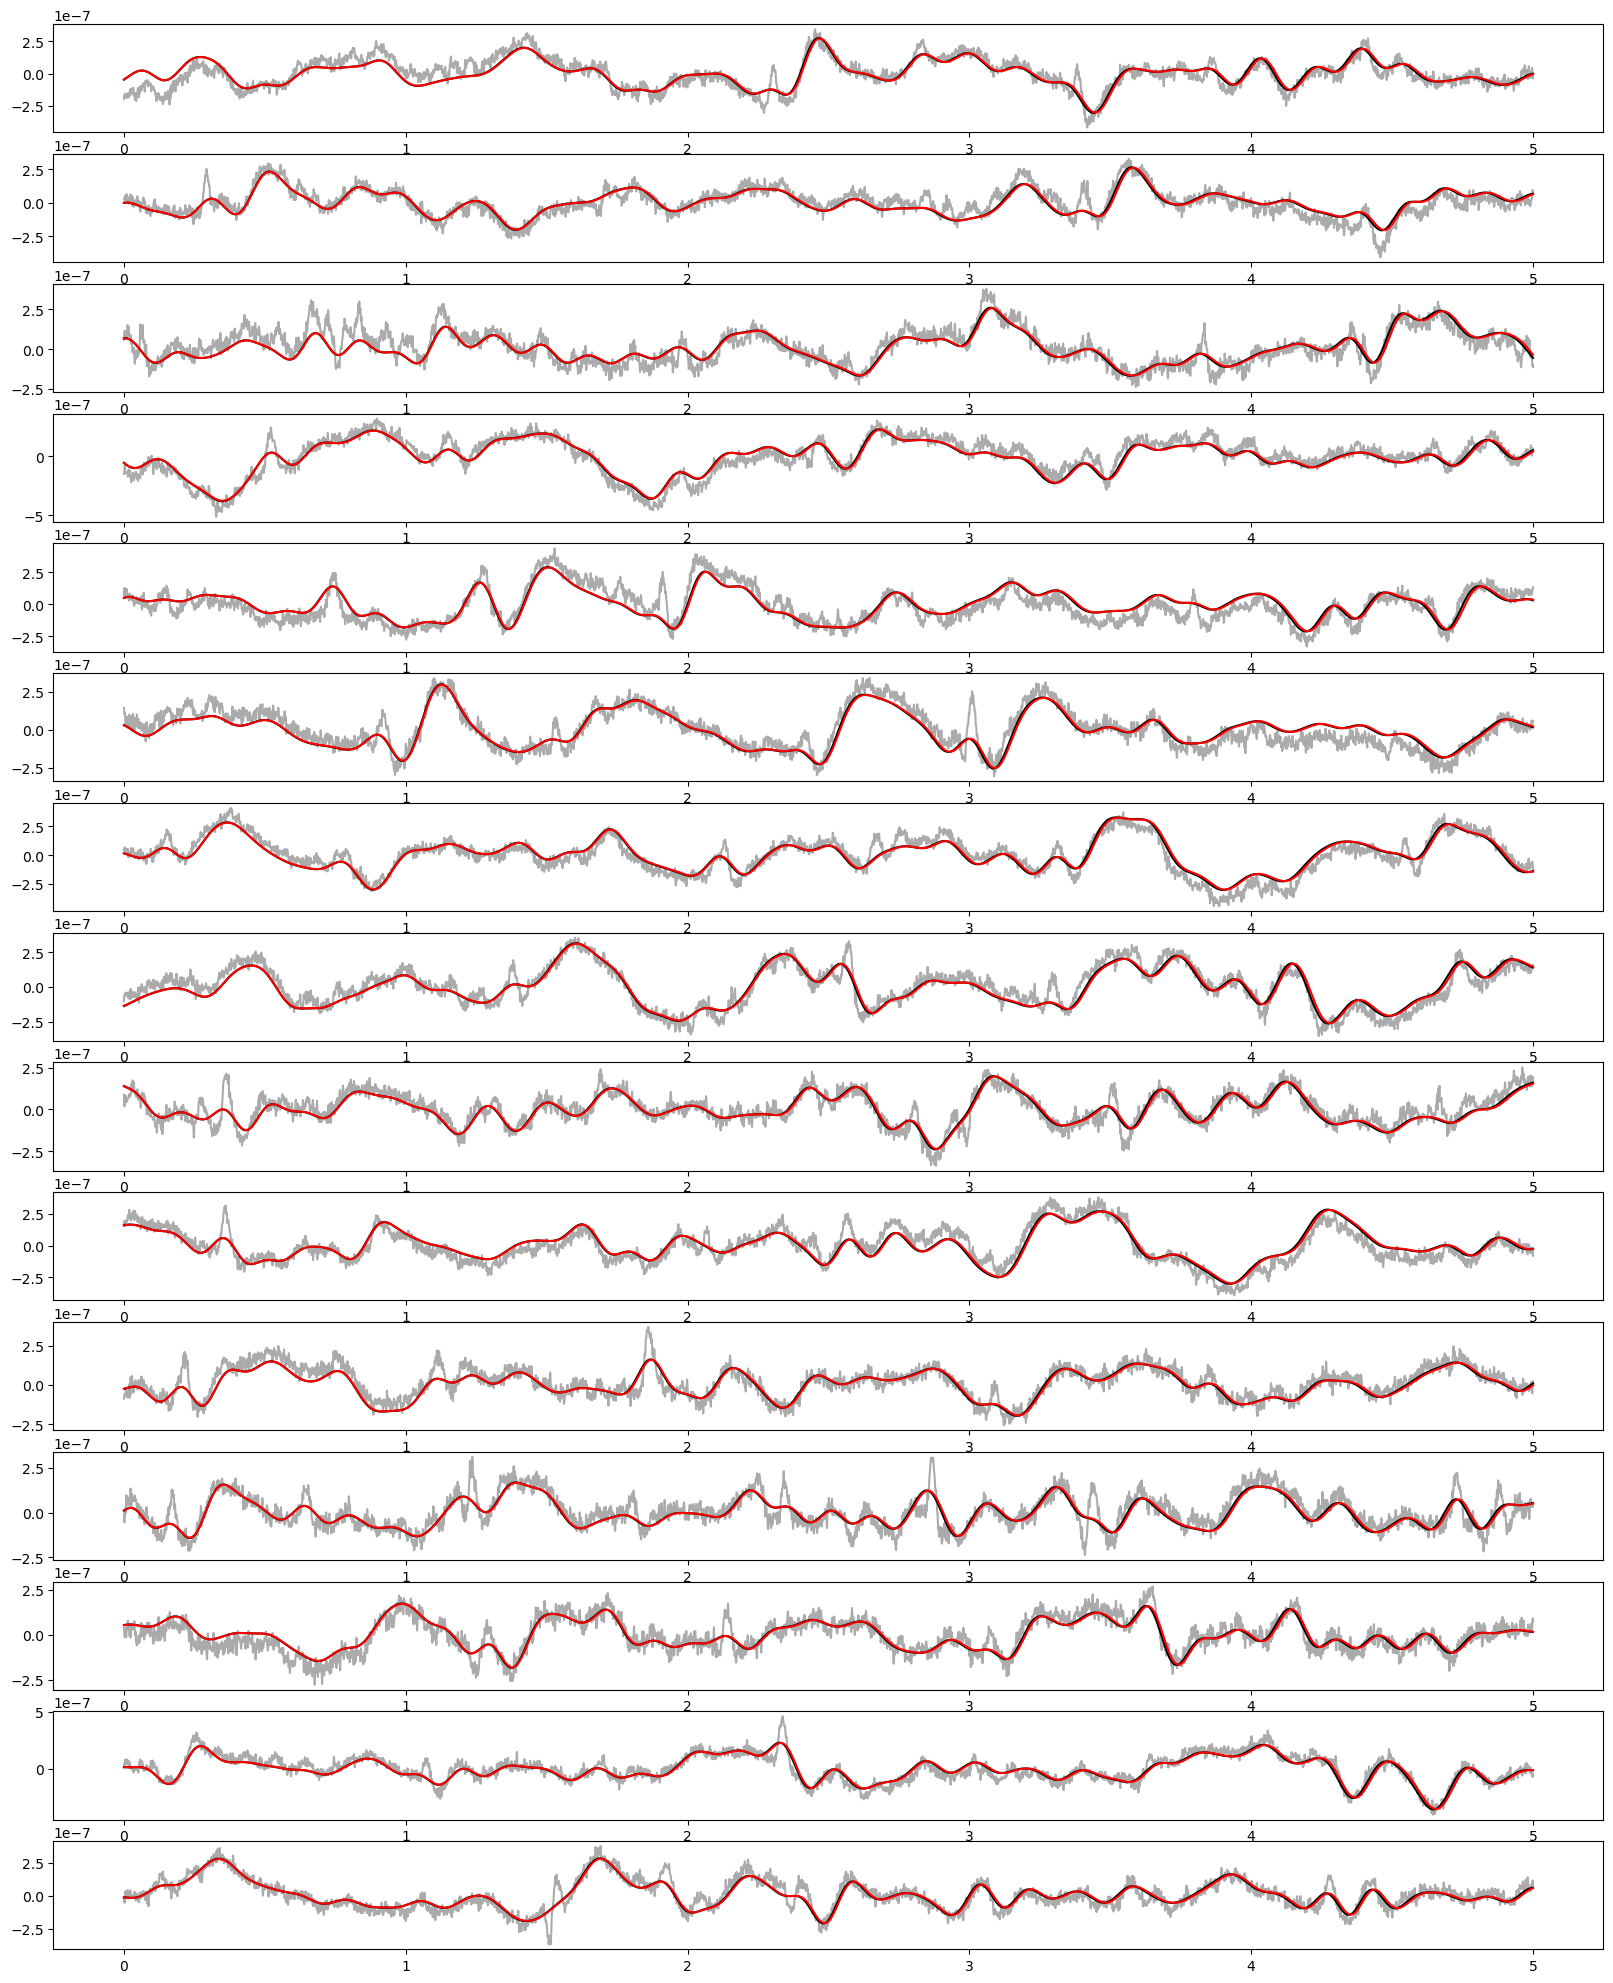

In [11]:
BLOCK_SIZE = 5 # Seconds
BLOCK_N    = 15
plt.figure(figsize=(20, 25))
for i in range(BLOCK_N):
    plt.subplot(BLOCK_N, 1, i+1)
    
    # gray: orig TS
    plt.plot(np.linspace(0, BLOCK_SIZE, ori_fs*BLOCK_SIZE), 
             aParcelTS[i*ori_fs*BLOCK_SIZE:(i+1)*ori_fs*BLOCK_SIZE], 'k', alpha=0.33)
    
    # black: filtered data
    plt.plot(np.linspace(0, BLOCK_SIZE, ori_fs*BLOCK_SIZE), 
             highpass[i*ori_fs*BLOCK_SIZE:(i+1)*ori_fs*BLOCK_SIZE], 'k')
    
    # red: filtered and decimated
    plt.plot(np.linspace(0, BLOCK_SIZE, fs*BLOCK_SIZE), data[i*fs*BLOCK_SIZE:(i+1)*fs*BLOCK_SIZE], 'r')
    

In [12]:
###################################################################################
fs           = ori_fs // decimate    
###################################################################################


bpTS         = np.zeros([parcelTS.shape[0], signal.decimate(parcelTS[0], decimate).shape[0]])


# band-pass the data
for i in np.arange(0,200):
    
    aParcelTS            = parcelTS[i]    
    lowpass_data         = butter_lowpass(aParcelTS, LOW_PASS, ori_fs)
    highpass             = butter_highpass(lowpass_data, HI_PASS, ori_fs)
    bpTS[i, :]           = signal.decimate(highpass, decimate)
    
del lowpass_data
print('Band-pass done for the parcel time series, now will fit BatchCDL!')

Band-pass done for the parcel time series, now will fit BatchCDL!


In [13]:
split_parcTS = split_signal(bpTS[None], 8)
print('split_parcTS.shape:', split_parcTS.shape)


# Define the shape of the dictionary

n_times_atom = int(round(fs * ATOM_DURATION)) 
cdl = BatchCDL(
    # Shape of the dictionary
    n_atoms=n_atoms,
    n_times_atom=n_times_atom,
    # Request a rank1 dictionary with unit norm temporal and spatial maps
    rank1=True, uv_constraint='separate',
    # Initialize the dictionary with random chunk from the data
    D_init='chunk',
    # rescale the regularization parameter to be 20% of lambda_max
    lmbd_max="scaled", reg=.2,
    # Number of iteration for the alternate minimization and cvg threshold
    n_iter=100, eps=1e-4,
    # solver for the z-step
    solver_z="lgcd", solver_z_kwargs={'tol': 1e-2, 'max_iter': 1000},
    # solver for the d-step
    solver_d='alternate_adaptive', solver_d_kwargs={'max_iter': 300},
    # Technical parameters
    verbose=10, random_state=0, n_jobs=40)



######################################### FIT IT
t1 = time.time()
cdl.fit(split_parcTS)
del split_parcTS   
######################################### FIT IT

t2 = time.time()
print('\nN of atoms: ', n_atoms, ', Num of Jobs: ', N_JOBS)
print('Low: ', LOW_PASS, 'Hz, High:', HI_PASS, 'Hz')
print(f"Finished at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t2))}")
print('Time spent:', (t2-t1)/60, ' mins.' )

split_parcTS.shape: (8, 200, 7662)
[BatchCDL] CD iterations 0 / 100
[BatchCDL] lambda = 3.266e+01
[BatchCDL] Objective (z) : 5.954e+06 (sparsity: 2.503e-03)
[BatchCDL] Objective (d) : 5.902e+06
[BatchCDL] CD iterations 1 / 100
[BatchCDL] Objective (z) : 5.873e+06 (sparsity: 3.276e-03)
[BatchCDL] Objective (d) : 5.856e+06
[BatchCDL] CD iterations 2 / 100
[BatchCDL] Objective (z) : 5.845e+06 (sparsity: 3.660e-03)
[BatchCDL] Objective (d) : 5.836e+06
[BatchCDL] CD iterations 3 / 100
[BatchCDL] Objective (z) : 5.830e+06 (sparsity: 3.894e-03)
[BatchCDL] Objective (d) : 5.825e+06
[BatchCDL] CD iterations 4 / 100
[BatchCDL] Objective (z) : 5.821e+06 (sparsity: 4.047e-03)
[BatchCDL] Objective (d) : 5.817e+06
[BatchCDL] CD iterations 5 / 100
[BatchCDL] Objective (z) : 5.813e+06 (sparsity: 4.145e-03)
[BatchCDL] Objective (d) : 5.810e+06
[BatchCDL] CD iterations 6 / 100
[BatchCDL] Objective (z) : 5.808e+06 (sparsity: 4.220e-03)
[BatchCDL] Objective (d) : 5.805e+06
[BatchCDL] CD iterations 7 / 100

NameError: name 'N_JOBS' is not defined

(12, 500)


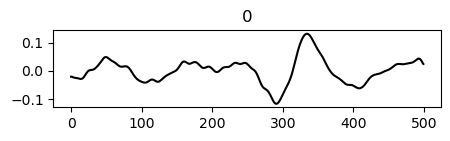

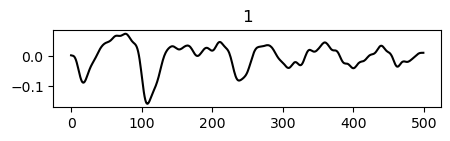

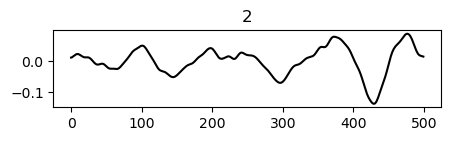

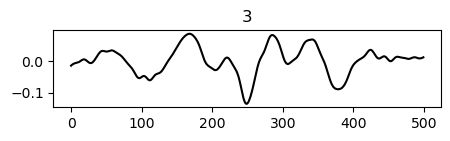

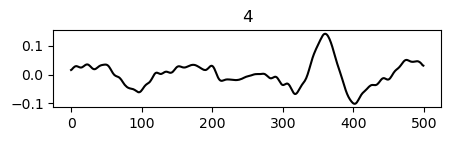

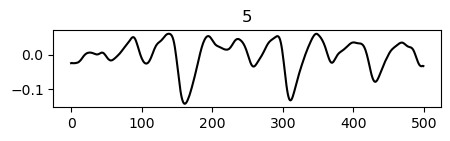

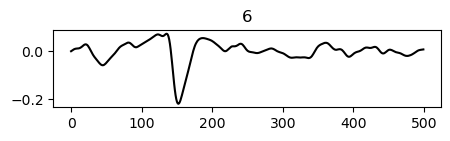

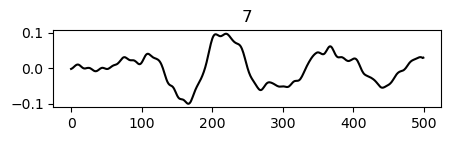

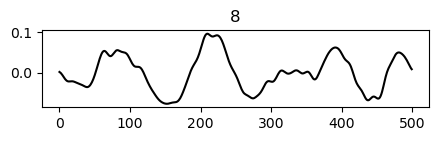

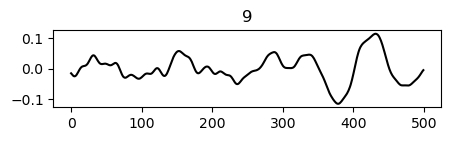

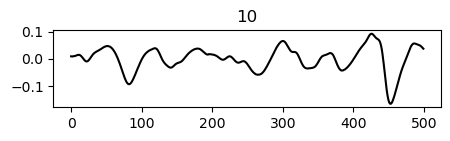

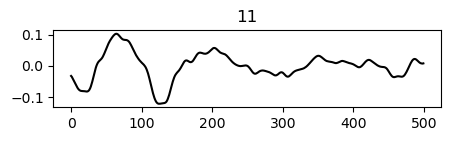

0390_set4_BB_0.5-7Hz_12_Atoms_5(s).mat


In [14]:
u_hat = cdl.u_hat_ # spatial
v_hat = cdl.v_hat_ # temporal
print(v_hat.shape)

for i in range(n_atoms):
    plt.figure(figsize=(5, 1))
    plt.plot(v_hat[i, :], 'k')
    plt.title(i)
plt.show()

MAT_FILE = filepath[33:37] + '_' + filepath[38:42] + '_BB_' + str(HI_PASS) + '-' + str(LOW_PASS) + 'Hz_' + str(n_atoms) + '_Atoms_' + str(ATOM_DURATION) + '(s).mat'
savemat('./mat_files/' + MAT_FILE, {"u_hat": u_hat, "v_hat": v_hat})
print(MAT_FILE)

In [ ]:
plt.figure(figsize=(6, 2))
plt.plot(v_hat.T, 'k', alpha=0.25)    
plt.show()

In [ ]:
values = u_hat.shape[9]
# axes should be a 2x2 numpy array
fig, axes = plt.subplots(figsize=(10,10), ncols=2, nrows=2)

# the actual plotting function. 
draw_four_views(axes, values, surf_parcel_names, brain_3d_surfaces, cmap=CMAP, norm_values=Z_LIM)
print(freq_bank[IDX], ' Hz')